# Data Preprocessing

In [2]:
import pandas as pd 
# Load the NYT dataset
nyt_df = pd.read_csv("China_article_nyt2024.csv")
nyt_df.head()

,headline,pub_date,web_url,news_desk,document_type,snippet,abstract,lead_paragraph,is_china_related,full_text
0,China Auto Giant BYD Sells More Electric Vehic...,2024-01-01T12:43:30+0000,https://www.nytimes.com/2024/01/01/business/by...,Business,article,"Sales by BYD, the country’s dominant automaker...","Sales by BYD, the country’s dominant automaker...",The Chinese corporate giant BYD said Monday th...,True,"ADVERTISEMENT Sales by BYD, the country’s domi..."
1,India Is Chasing China’s Economy. But Somethin...,2024-01-02T05:01:27+0000,https://www.nytimes.com/2024/01/02/business/in...,Business,article,Long-term investment in India by businesses is...,Long-term investment in India by businesses is...,India’s economy is booming. Stock prices are t...,True,Long-term investment in India by businesses is...
2,"Jimmy Lai, Hong Kong Media Executive, Pleads N...",2024-01-02T11:00:05+0000,https://www.nytimes.com/2024/01/02/world/asia/...,Foreign,article,The prosecution accused him of colluding with ...,The prosecution accused him of colluding with ...,"Jimmy Lai, a veteran pro-democracy figure in H...",True,ADVERTISEMENT The prosecution accused him of c...
3,Abrupt Dismissals Point to Xi Jinping’s Quiet ...,2024-01-03T06:32:24+0000,https://www.nytimes.com/2024/01/03/world/asia/...,Foreign,article,The purge of several commanders from China’s l...,The purge of several commanders from China’s l...,The expelled officials included some of the br...,True,ADVERTISEMENT The purge of several commanders ...
4,Thursday Briefing: Blasts in Iran Kill Dozens,2024-01-03T21:04:18+0000,https://www.nytimes.com/2024/01/03/briefing/ir...,NYTNow,article,"Plus, China shakes up its military.","Plus, China shakes up its military.",A pair of explosions yesterday at a commemorat...,True,"ADVERTISEMENT Plus, China shakes up its milita..."


In [3]:
#check the data with unknown newsdesk
print(nyt_df[nyt_df['news_desk'] == 'Unknown'])
# change all unkonwn nesdesk to multimedia
nyt_df.loc[nyt_df['news_desk'] == 'Unknown', 'news_desk'] = 'Multimedia'
print(nyt_df[nyt_df['news_desk'] == 'Unknown'])


                                              headline  \
45      Landslide in China Wipes Out Fields and Houses   
85         Heavy Snow in China Disrupts Holiday Travel   
100             Chasing Indonesia’s Massive Youth Vote   
175  United States House Passes Bill That Could Ban...   
185  Biden Embraces TikTok Amid National Security C...   
210  TikTok Changed His Life. Then India Banned the...   
253                  Powerful Earthquake Shakes Taiwan   
256                  Powerful Earthquake Shakes Taiwan   
260  Workers Stuck on Mountain After Taiwan Earthquake   
316  Behind Our Investigation Into a Chinese Doping...   
319  ‘History Will Judge It Well,’ Speaker Johnson ...   
327             Earthquakes in Taiwan Damage Buildings   
339  Biden Says Aid Bill for Ukraine and Israel Wil...   
372                On the Road for a Modern Pilgrimage   
376  University of Chicago President Says Pro-Pales...   
384                                Will You Look at Me   
423           

In [4]:
# drop where full text is missing
nyt_df = nyt_df.dropna(subset=["full_text"])

In [5]:
# drop the newsdesk where articles length less than 10
news_desk_drop=["Business Day", "Multimedia", "Technology", "World"]
nyt_df = nyt_df[~nyt_df["news_desk"].isin(news_desk_drop)]

In [6]:
#clean the date column
nyt_df["pub_date"] = pd.to_datetime(nyt_df["pub_date"], errors='coerce').dt.date
nyt_df.dropna(subset=["pub_date"], inplace=True)
print(nyt_df["pub_date"].head())

0    2024-01-01
1    2024-01-02
2    2024-01-02
3    2024-01-03
4    2024-01-03
Name: pub_date, dtype: object


Data cleaning

In [7]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    tokens = word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]
    return ' '.join(tokens)

nyt_df['clean_text'] = nyt_df['full_text'].apply(preprocess)

[nltk_data] Downloading package punkt to /Users/apple/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/apple/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/apple/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# LDA

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
X = vectorizer.fit_transform(nyt_df['clean_text'])

lda = LatentDirichletAllocation(n_components=10, random_state=42)
lda.fit(X)

# Print topics
words = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
    top_words = [words[i] for i in topic.argsort()[:-11:-1]]
    print(f"Topic {topic_idx}: {' '.join(top_words)}")

Topic 0: tiktok said trump state company china american united chinese biden
Topic 1: like think people going tiktok thing really time say right
Topic 2: term said hong kong time updated new trump election year
Topic 3: taiwan china chinese said military island state beijing official united
Topic 4: china said chinese year country state people official government foreign
Topic 5: said company chinese china year biden tariff vehicle state electric
Topic 6: china said year chinese government country economy city people woman
Topic 7: company china said year india chinese new tesla factory time
Topic 8: chinese said wada china hong kong positive swimmer time agency
Topic 9: china russia state said chinese united country european trade war


In [9]:
topic_distributions = lda.transform(X)
nyt_df['dominant_topic'] = topic_distributions.argmax(axis=1)

In [10]:
identity_map = {
    0: "geopolitical_roles",
    1: "shared_values",
    2: "historical_narratives",
    3: "geopolitical_roles",
    4: "leadership_portrayals",
    5: "geopolitical_roles",
    6: "shared_values",
    7: "geopolitical_roles",
    8: "shared_values",
    9: "geopolitical_roles"
}

nyt_df['identity_dimension'] = nyt_df['dominant_topic'].map(identity_map)

In [11]:
identity_counts = nyt_df['identity_dimension'].value_counts()
print(identity_counts)

identity_dimension
geopolitical_roles       453
historical_narratives    188
shared_values            170
leadership_portrayals     97
Name: count, dtype: int64


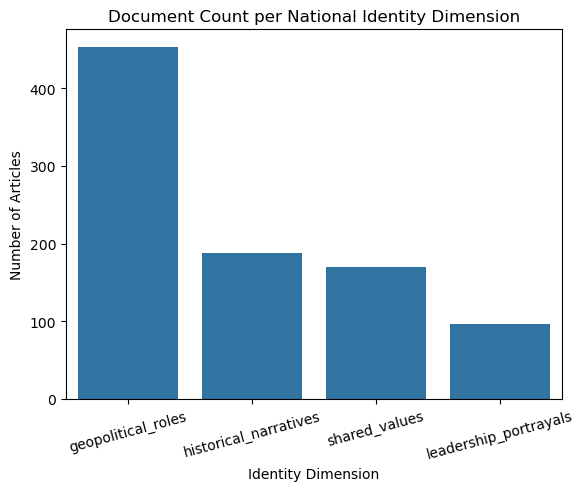

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='identity_dimension', data=nyt_df, order=identity_counts.index)
plt.title("Document Count per National Identity Dimension")
plt.xlabel("Identity Dimension")
plt.ylabel("Number of Articles")
plt.xticks(rotation=15)
plt.show()

<Axes: title={'center': 'LDA Topic Trends Over Time'}, xlabel='month'>

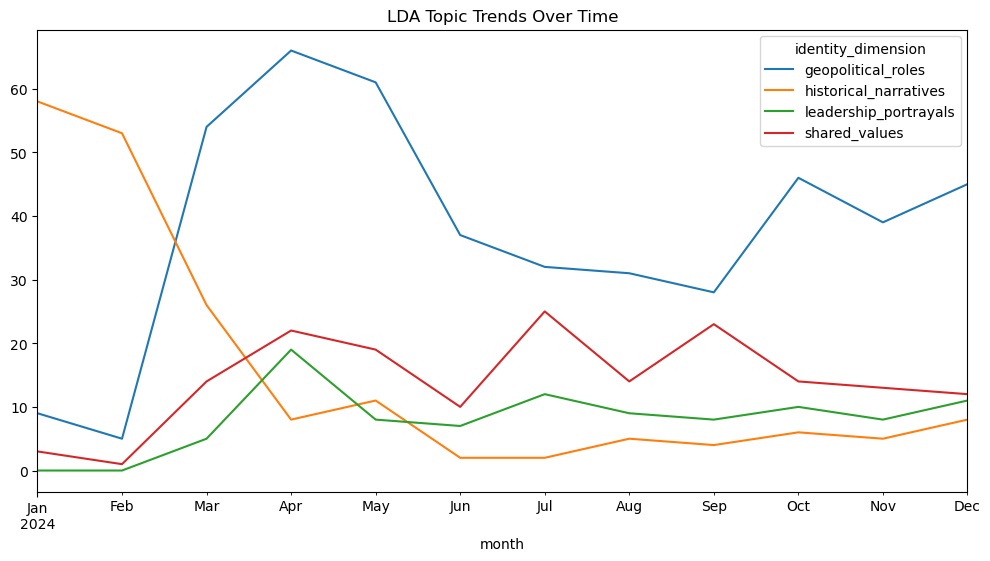

In [13]:
nyt_df['pub_date'] = pd.to_datetime(nyt_df['pub_date'], errors='coerce')  # Coerce invalid dates to NaT
nyt_df['month'] = nyt_df['pub_date'].dt.to_period('M')
topic_over_time = nyt_df.groupby(['month', 'identity_dimension']).size().unstack(fill_value=0)

# Plot
topic_over_time.plot(figsize=(12, 6), title='LDA Topic Trends Over Time')

In [14]:
correlation_matrix = topic_over_time.corr()
print(correlation_matrix)

identity_dimension     geopolitical_roles  historical_narratives  \
identity_dimension                                                 
geopolitical_roles               1.000000              -0.614102   
historical_narratives           -0.614102               1.000000   
leadership_portrayals            0.728599              -0.762931   
shared_values                    0.608911              -0.755764   

identity_dimension     leadership_portrayals  shared_values  
identity_dimension                                           
geopolitical_roles                  0.728599       0.608911  
historical_narratives              -0.762931      -0.755764  
leadership_portrayals               1.000000       0.771910  
shared_values                       0.771910       1.000000  


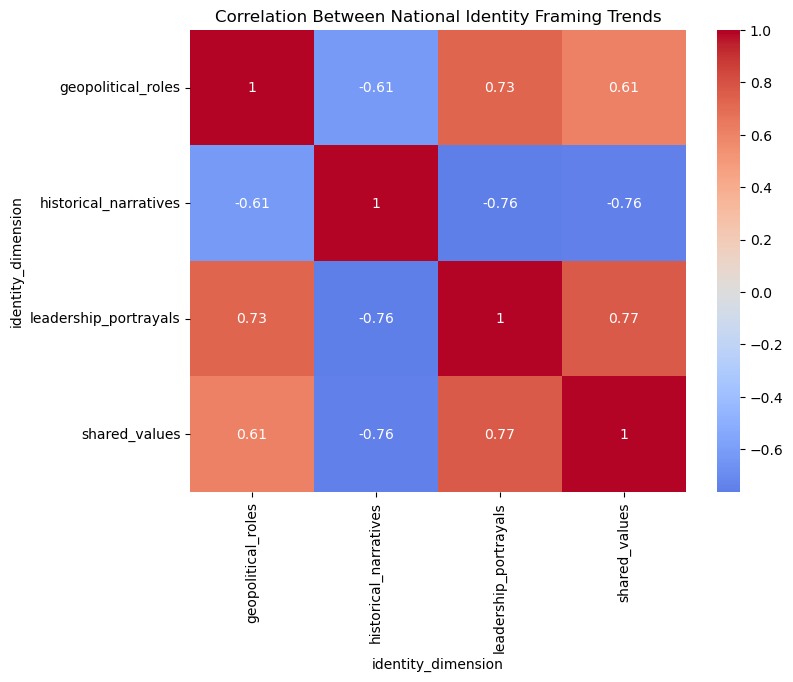

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Between National Identity Framing Trends")
plt.show()

In [16]:
import warnings
from statsmodels.tsa.stattools import grangercausalitytests
import pandas as pd
import itertools

# Use your topic_over_time DataFrame
dimensions = topic_over_time.columns.tolist()
max_lag = 2
results = []

# Suppress specific FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)

for cause, effect in itertools.permutations(dimensions, 2):
    try:
        data = topic_over_time[[cause, effect]].dropna()
        test_result = grangercausalitytests(data[[effect, cause]], maxlag=max_lag, verbose=False)

        p_values = [test_result[lag][0]['ssr_ftest'][1] for lag in range(1, max_lag + 1)]
        min_p = min(p_values)

        results.append({
            'cause': cause,
            'effect': effect,
            'min_p_value': min_p
        })
    except Exception as e:
        results.append({
            'cause': cause,
            'effect': effect,
            'min_p_value': None,
            'error': str(e)
        })

# Output table
granger_df = pd.DataFrame(results).sort_values(by='min_p_value')
print(granger_df[['cause', 'effect', 'min_p_value']])

                    cause                 effect  min_p_value
4   historical_narratives  leadership_portrayals     0.004317
7   leadership_portrayals  historical_narratives     0.085558
3   historical_narratives     geopolitical_roles     0.098241
5   historical_narratives          shared_values     0.100037
9           shared_values     geopolitical_roles     0.114193
1      geopolitical_roles  leadership_portrayals     0.123235
6   leadership_portrayals     geopolitical_roles     0.229123
8   leadership_portrayals          shared_values     0.349052
11          shared_values  leadership_portrayals     0.401993
2      geopolitical_roles          shared_values     0.403945
0      geopolitical_roles  historical_narratives     0.468428
10          shared_values  historical_narratives     0.785258


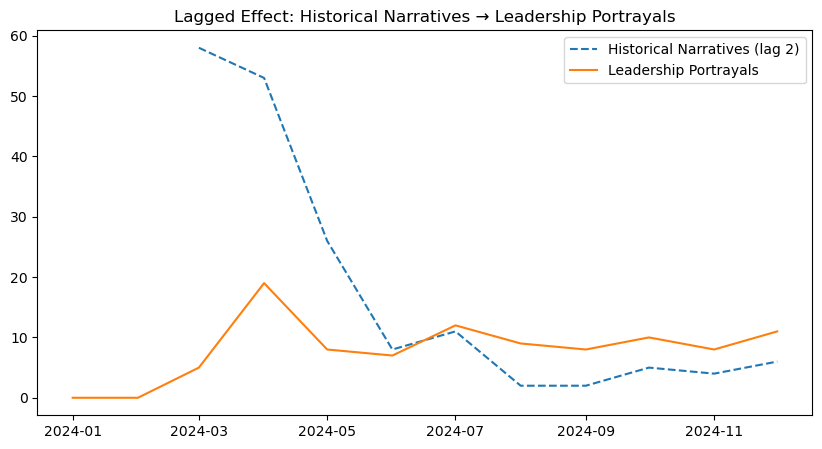

In [17]:
import matplotlib.pyplot as plt

lagged = topic_over_time.copy()
lagged['historical_narratives_lag2'] = lagged['historical_narratives'].shift(2)

plt.figure(figsize=(10, 5))
plt.plot(lagged.index.to_timestamp(), lagged['historical_narratives_lag2'], label='Historical Narratives (lag 2)', linestyle='--')
plt.plot(lagged.index.to_timestamp(), lagged['leadership_portrayals'], label='Leadership Portrayals')
plt.legend()
plt.title("Lagged Effect: Historical Narratives → Leadership Portrayals")
plt.show()

Granger causality analysis suggests that increases in historical narrative framing precede leadership portrayals (p = 0.004), implying that media may frame leadership legitimacy through historical continuity or revision.”

# Sentence-BERT + UMAP + KMeans Clustering

In [18]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-mpnet-base-v2')  
embeddings = model.encode(nyt_df['clean_text'].tolist(), show_progress_bar=True)

Batches:   0%|          | 0/29 [00:00<?, ?it/s]

In [19]:
import umap

reducer = umap.UMAP(n_neighbors=15, n_components=2, random_state=42)
embedding_2d = reducer.fit_transform(embeddings)

nyt_df['umap_x'] = embedding_2d[:, 0]
nyt_df['umap_y'] = embedding_2d[:, 1]

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


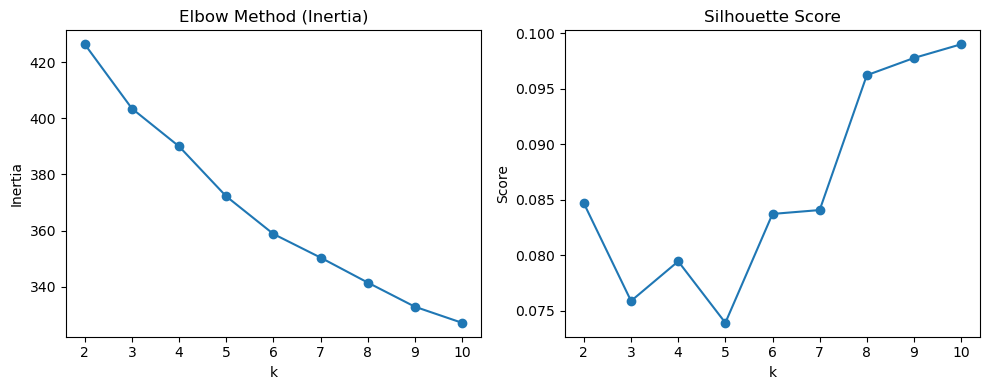

In [20]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

inertias = []
silhouettes = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(embeddings)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(embeddings, kmeans.labels_))

# Plot elbow
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(k_range, inertias, marker='o')
plt.title("Elbow Method (Inertia)")
plt.xlabel("k")
plt.ylabel("Inertia")

plt.subplot(1,2,2)
plt.plot(k_range, silhouettes, marker='o')
plt.title("Silhouette Score")
plt.xlabel("k")
plt.ylabel("Score")
plt.tight_layout()
plt.show()

In [21]:
optimal_k = 8  # Replace with your actual choice
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
nyt_df['cluster'] = kmeans.fit_predict(embeddings)

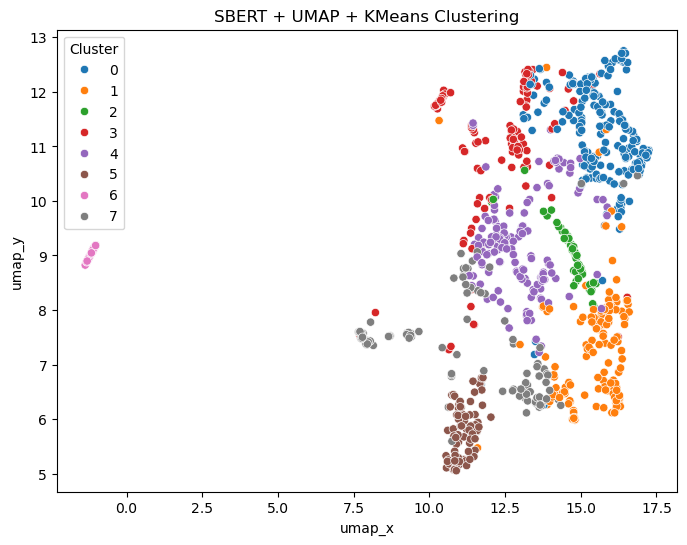

In [22]:
import seaborn as sns

plt.figure(figsize=(8,6))
sns.scatterplot(data=nyt_df, x='umap_x', y='umap_y', hue='cluster', palette='tab10')
plt.title('SBERT + UMAP + KMeans Clustering')
plt.legend(title="Cluster")
plt.show()

In [23]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english', max_features=5000)
X = vectorizer.fit_transform(nyt_df['clean_text'])
words = vectorizer.get_feature_names_out()

for i in range(8):
    cluster_mask = nyt_df['cluster'] == i
    cluster_docs = X[cluster_mask.values, :]
    
    word_sums = cluster_docs.sum(axis=0).A1
    top_idx = word_sums.argsort()[::-1][:10]
    top_words = [words[j] for j in top_idx]
    
    print(f"Cluster {i}: {', '.join(top_words)}")



    

Cluster 0: china, said, chinese, company, state, year, united, tariff, country, car
Cluster 1: china, said, russia, state, chinese, country, united, ukraine, president, war
Cluster 2: taiwan, china, said, chinese, island, beijing, lai, military, state, taiwanese
Cluster 3: china, said, year, chinese, people, time, term, city, advertisement, country
Cluster 4: china, said, chinese, government, hong, kong, year, state, official, company
Cluster 5: tiktok, said, company, app, chinese, law, bytedance, trump, state, government
Cluster 6: wada, chinese, swimmer, positive, said, time, doping, agency, athlete, china
Cluster 7: like, said, think, people, time, tiktok, china, going, new, year


In [24]:
anchors = [
    "global power", "military threat", "world leadership", "geopolitical influence",
    "historical legacy", "past injustice", "imperialism",
    "strong leadership", "state governance", "dictatorship",
    "freedom and democracy", "rule of law", "human rights", "national pride"
]
anchor_vecs = model.encode(anchors)

In [25]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

cluster_labels = []

for i in range(8):
    cluster_vecs = embeddings[nyt_df['cluster'] == i]
    centroid = np.mean(cluster_vecs, axis=0, keepdims=True)
    
    sims = cosine_similarity(centroid, anchor_vecs)[0]
    best_idx = np.argmax(sims)
    best_anchor = anchors[best_idx]
    
    cluster_labels.append((i, best_anchor, round(sims[best_idx], 3)))

In [26]:
for cid, label, score in cluster_labels:
    print(f"Cluster {cid} → {label} (cosine sim: {score})")

Cluster 0 → geopolitical influence (cosine sim: 0.39500001072883606)
Cluster 1 → geopolitical influence (cosine sim: 0.5099999904632568)
Cluster 2 → geopolitical influence (cosine sim: 0.45899999141693115)
Cluster 3 → state governance (cosine sim: 0.36399999260902405)
Cluster 4 → state governance (cosine sim: 0.39500001072883606)
Cluster 5 → dictatorship (cosine sim: 0.3580000102519989)
Cluster 6 → state governance (cosine sim: 0.2849999964237213)
Cluster 7 → historical legacy (cosine sim: 0.35600000619888306)


In [27]:
label_map = {cid: label for cid, label, _ in cluster_labels}
nyt_df['semantic_label'] = nyt_df['cluster'].map(label_map)

In [28]:
centroids = nyt_df.groupby('cluster')[['umap_x', 'umap_y']].mean()
centroids['semantic_label'] = centroids.index.map(label_map)

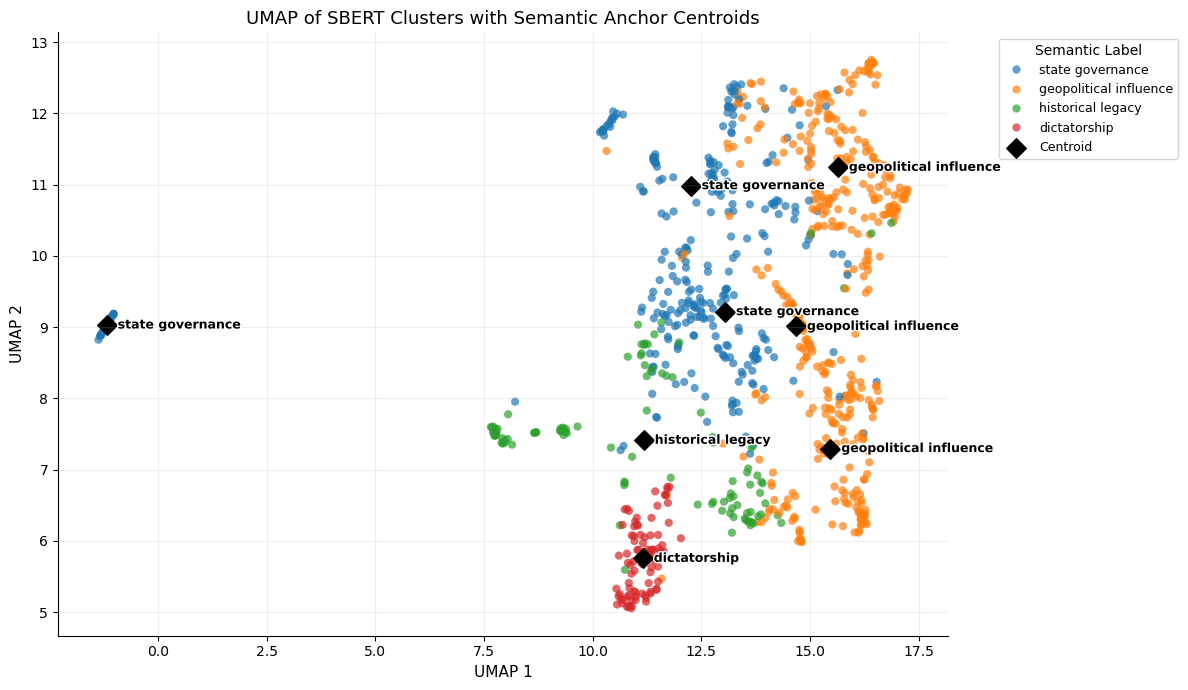

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patheffects as pe

plt.figure(figsize=(12, 7))

# Use a clean, professional palette
palette = sns.color_palette("tab10", n_colors=nyt_df['semantic_label'].nunique())

# Plot UMAP points
sns.scatterplot(
    data=nyt_df,
    x='umap_x', y='umap_y',
    hue='semantic_label',
    palette=palette,
    alpha=0.7,
    s=35,
    edgecolor='none'
)

# Plot centroids as diamonds
plt.scatter(
    centroids['umap_x'],
    centroids['umap_y'],
    c='black',
    marker='D',  # Diamond marker
    s=100,
    label='Centroid'
)

# Annotate centroids with smaller font
for _, row in centroids.iterrows():
    plt.text(
        row['umap_x'] + 0.25, row['umap_y'],
        row['semantic_label'],
        fontsize=9,
        weight='bold',
        path_effects=[pe.withStroke(linewidth=2, foreground="white")],
        ha='left',
        va='center'
    )

# Style
plt.title("UMAP of SBERT Clusters with Semantic Anchor Centroids", fontsize=13)
plt.xlabel("UMAP 1", fontsize=11)
plt.ylabel("UMAP 2", fontsize=11)
plt.legend(title='Semantic Label', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.grid(alpha=0.2)
sns.despine()
plt.tight_layout()
plt.show()

In [30]:
anchor_map = {cid: anchor for cid, anchor, _ in cluster_labels}
nyt_df['merged_label'] = nyt_df['cluster'].map(anchor_map)

In [31]:
# Group by merged_label instead of cluster
centroids = nyt_df.groupby('merged_label')[['umap_x', 'umap_y']].mean().reset_index()

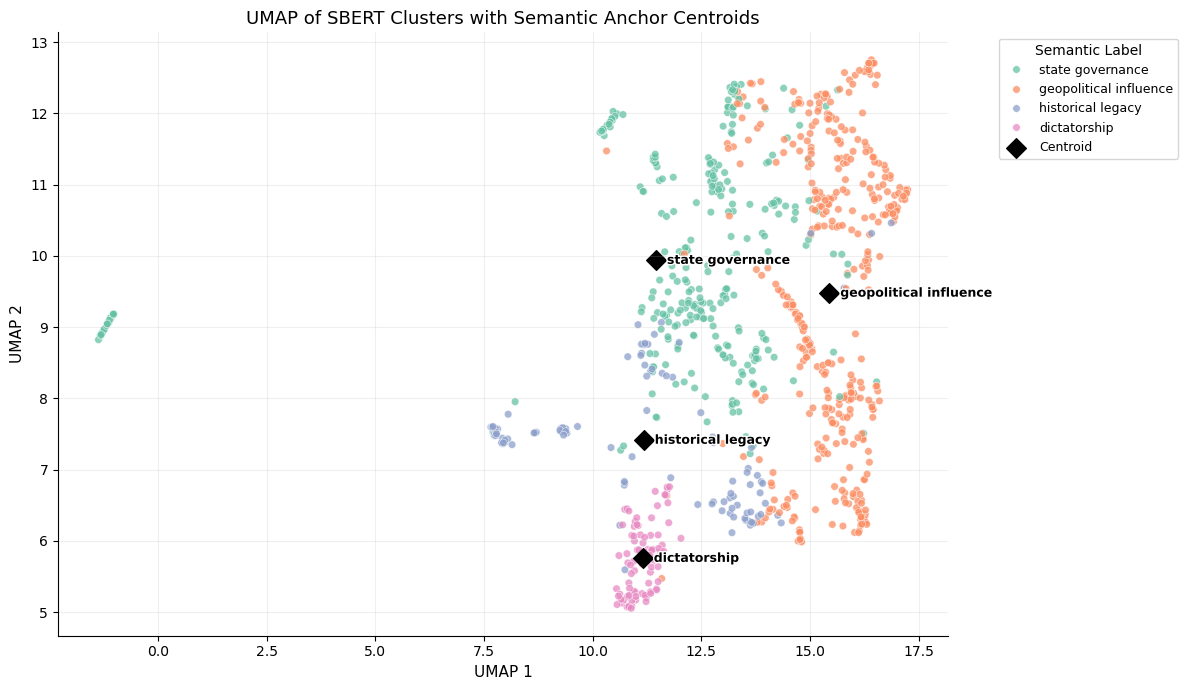

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patheffects as pe

plt.figure(figsize=(12, 7))

# Use a clean, professional palette
palette = sns.color_palette("tab10", n_colors=nyt_df['semantic_label'].nunique())

# Plot UMAP points
sns.scatterplot(
    data=nyt_df,
    x='umap_x', y='umap_y',
    hue='merged_label',
    palette='Set2',
    s=30,
    alpha=0.75
)
# Plot centroids as diamonds
plt.scatter(
    centroids['umap_x'],
    centroids['umap_y'],
    c='black',
    marker='D',  # Diamond marker
    s=100,
    label='Centroid'
)

# Annotate centroids with smaller font


for _, row in centroids.iterrows():
    plt.text(
        row['umap_x'] + 0.25, row['umap_y'],
        row['merged_label'],
        fontsize=9,
        weight='bold',
        path_effects=[pe.withStroke(linewidth=2, foreground="white")],
        ha='left',
        va='center'
    )

# Style
plt.title("UMAP of SBERT Clusters with Semantic Anchor Centroids", fontsize=13)
plt.xlabel("UMAP 1", fontsize=11)
plt.ylabel("UMAP 2", fontsize=11)
plt.legend(title='Semantic Label', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.grid(alpha=0.2)
sns.despine()
plt.tight_layout()
plt.show()

# BERT Model

Device set to use mps:0


,mean,std,count
merged_label,,,
dictatorship,-0.976084,0.161233,88
geopolitical influence,-0.928443,0.300398,406
state governance,-0.894019,0.373654,305
historical legacy,-0.792588,0.558050,109


<Axes: title={'center': 'Average Sentiment Over Time by National Identity Frame'}, xlabel='month'>

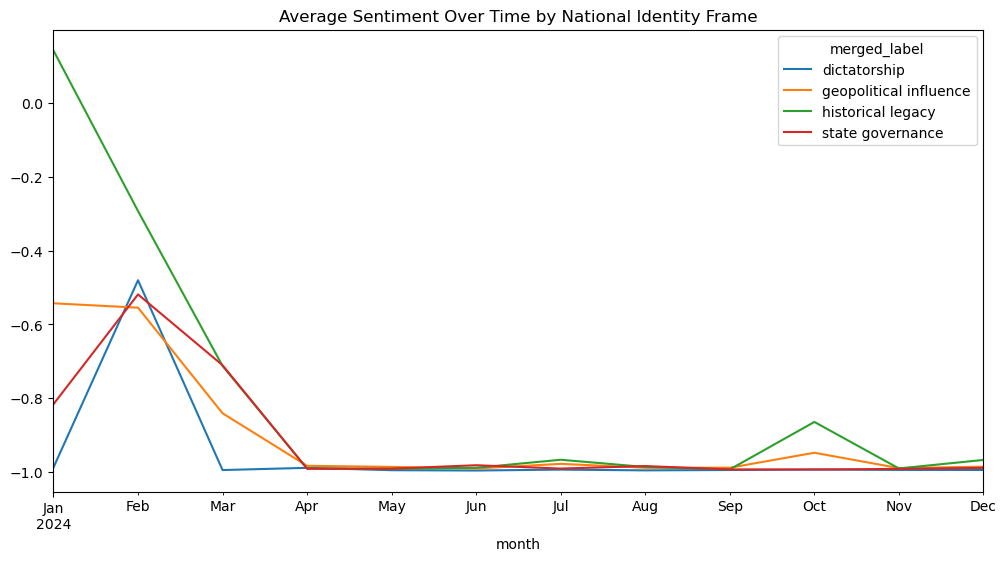

In [33]:
from transformers import pipeline
import pandas as pd

# 2) create a BERT‐based sentiment analyzer
#    using DistilBERT fine-tuned on SST-2 (binary pos/neg)
analyzer = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english",
    tokenizer="distilbert-base-uncased-finetuned-sst-2-english",
    device=0       # or device=-1 for CPU
)

# 3) helper to map HuggingFace output to a single float in [-1, +1]
def bert_score(text):
    out = analyzer(text, truncation=True)[0]
    # if label is NEGATIVE, flip the sign
    return out["score"] if out["label"] == "POSITIVE" else -out["score"]

# 4) apply to your DataFrame (you can batch for speed if you like)
nyt_df["sentiment"] = nyt_df["clean_text"].apply(bert_score)

# 5) now your grouping, agg, and plot are unchanged:
sentiment_by_label = (
    nyt_df
    .groupby("merged_label")["sentiment"]
    .agg(["mean","std","count"])
    .sort_values("mean")
)
display(sentiment_by_label)

nyt_df["month"] = pd.to_datetime(nyt_df["pub_date"]).dt.to_period("M")
sentiment_over_time = (
    nyt_df
    .groupby(["month","merged_label"])["sentiment"]
    .mean()
    .unstack()
)
sentiment_over_time.plot(
    figsize=(12,6),
    title="Average Sentiment Over Time by National Identity Frame"
)

/var/folders/0k/7z1g8vr51n7_n_22vk6x3zrw0000gn/T/ipykernel_80011/1259035582.py:73: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=30, ha='right')


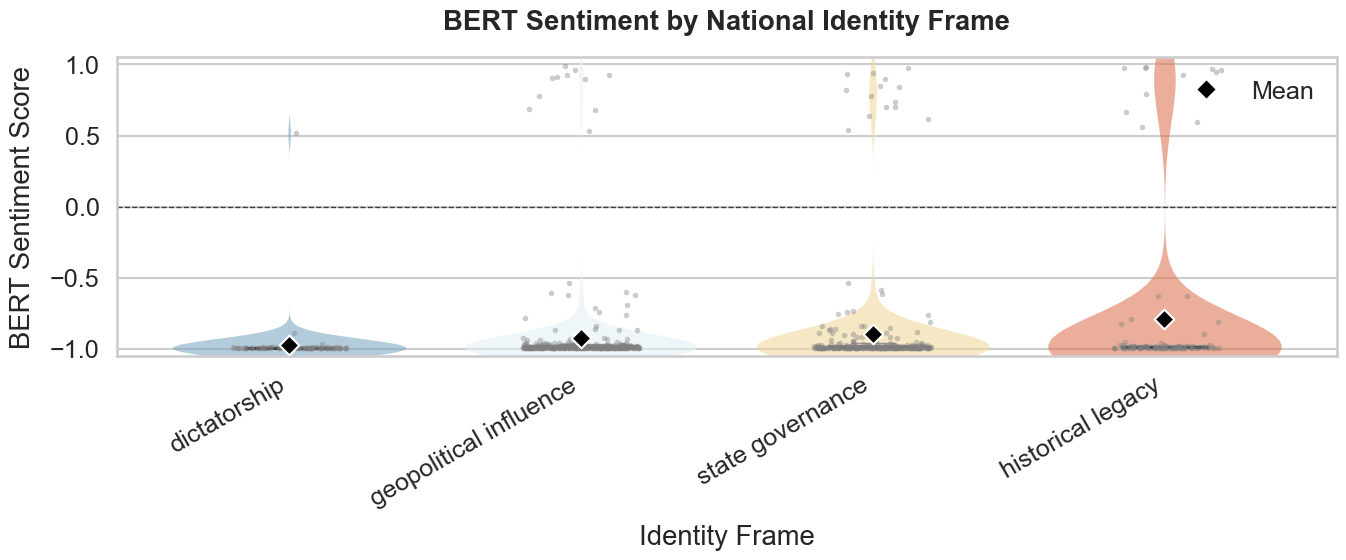

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

# 1) Compute the means & decide an order
means = nyt_df.groupby('merged_label')['sentiment'].mean().sort_values()
labels = means.index.tolist()

# 2) Set a clean seaborn theme
sns.set_theme(style="whitegrid", context="talk", font_scale=1.1)

# 3) Pick a diverging palette so that more‐negative frames are tinted redder
palette = sns.color_palette("RdYlBu_r", n_colors=len(labels))

# 4) Make the figure
fig, ax = plt.subplots(figsize=(14, 6))

# 5) Draw a violin “shadow” behind so readers see the full density
sns.violinplot(
    x='merged_label', y='sentiment', data=nyt_df,
    order=labels,
    palette=palette,
    inner=None,    # no inner bars—box will go on top
    alpha=0.6,
    linewidth=0,
    ax=ax
)

# 6) Draw a narrower boxplot on top for quartiles
sns.boxplot(
    x='merged_label', y='sentiment', data=nyt_df,
    order=labels,
    width=0.3,
    palette=["white"]*len(labels),  # white fill
    fliersize=0,
    linewidth=1.5,
    medianprops={'color':'black','linewidth':2},
    whiskerprops={'linewidth':1},
    capprops={'linewidth':1},
    zorder=2,
    ax=ax
)

# 7) Jittered points on top for individual scores
sns.stripplot(
    x='merged_label', y='sentiment', data=nyt_df,
    order=labels,
    jitter=0.2,
    size=4,
    alpha=0.4,
    color='gray',
    zorder=3,
    ax=ax
)

# 8) Overlay the mean as a large diamond
for i, lbl in enumerate(labels):
    ax.scatter(
        i, means[lbl],
        marker='D', s=100,
        color='black', edgecolor='white',
        zorder=4
    )

# 9) Zero‐line & y‐axis limits
ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.7, zorder=1)
ax.set_ylim(-1.05, 1.05)

# 10) Labels, title, ticks
ax.set_title("BERT Sentiment by National Identity Frame", pad=20, weight='bold')
ax.set_xlabel("Identity Frame", labelpad=10)
ax.set_ylabel("BERT Sentiment Score", labelpad=10)
ax.set_xticklabels(labels, rotation=30, ha='right')

# 11) Add a custom legend entry for the mean‐diamond
legend_elements = [
    Line2D([0], [0], marker='D', color='w',
           label='Mean', markerfacecolor='black', markersize=10)
]
ax.legend(handles=legend_elements, loc='upper right', frameon=False)

plt.tight_layout()
plt.show()

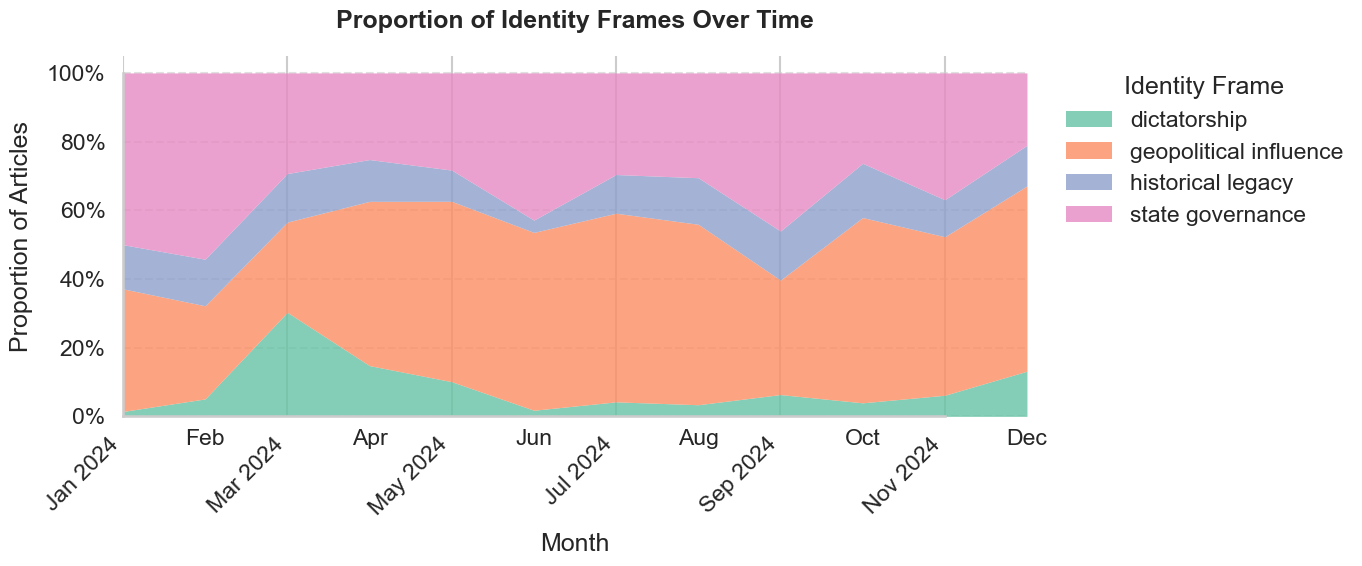

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 0) Parse your original publication dates
nyt_df['pub_date'] = pd.to_datetime(nyt_df['pub_date'])

# 1) Create a “month” column that floors each date to the first of its month
nyt_df['month'] = nyt_df['pub_date'].dt.to_period('M').dt.to_timestamp()

# 2) (Optional but recommended) Make that month column your index and sort
nyt_df = nyt_df.set_index('month').sort_index()

# 3) Compute monthly counts and proportions by your merged_label
monthly_counts = (
    nyt_df
    .groupby([nyt_df.index, 'merged_label'])
    .size()
    .unstack(fill_value=0)
)
monthly_prop = monthly_counts.div(monthly_counts.sum(axis=1), axis=0)

# 4) Seaborn styling
sns.set_theme(style="whitegrid", context="talk", font_scale=1.0)
palette = sns.color_palette("Set2", n_colors=monthly_prop.shape[1])

# 5) Plot the stacked area chart
fig, ax = plt.subplots(figsize=(14, 6))
monthly_prop.plot.area(ax=ax, color=palette, alpha=0.8, linewidth=0)

# 6) Force the x-axis limits to your real data range
ax.set_xlim(monthly_prop.index.min(), monthly_prop.index.max())

# 7) Manually pick tick dates every 2 months and format them
tick_dates = pd.date_range(
    start=monthly_prop.index.min(),
    end=monthly_prop.index.max(),
    freq='2MS'   # every 2nd month start
)
ax.set_xticks(tick_dates)
ax.set_xticklabels(
    [date.strftime('%b %Y') for date in tick_dates],
    rotation=45,
    ha='right'
)

# 8) Titles, labels, grid, and legend
ax.set_title("Proportion of Identity Frames Over Time", pad=20, weight='bold')
ax.set_xlabel("Month", labelpad=10)
ax.set_ylabel("Proportion of Articles", labelpad=10)
ax.yaxis.set_major_formatter(
    plt.FuncFormatter(lambda y, _: f"{y:.0%}")
)
ax.grid(axis='y', linestyle='--', alpha=0.6)
ax.legend(
    title="Identity Frame",
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    frameon=False
)

sns.despine(trim=True)
plt.tight_layout()
plt.show()

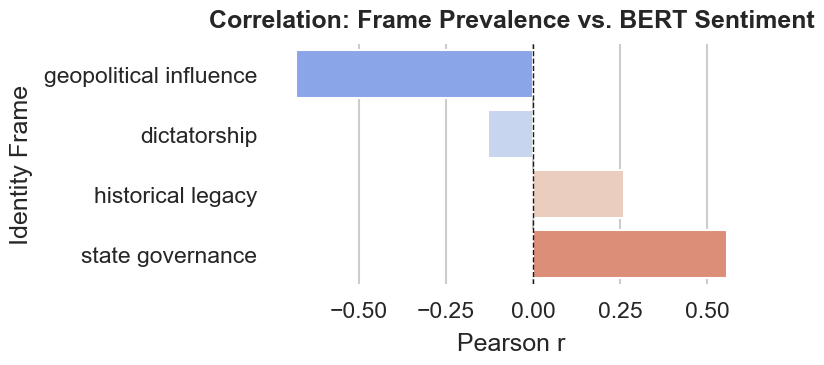

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 0) make sure your month indices align as Timestamps (if they’re Periods):
monthly_prop = monthly_prop.copy()
monthly_prop.index = pd.to_datetime(monthly_prop.index.astype(str))

sentiment_over_time = sentiment_over_time.copy()
sentiment_over_time.index = pd.to_datetime(sentiment_over_time.index.astype(str))

# --- 1) Compute per-frame correlations
corrs = {}
for frame in monthly_prop.columns:
    if frame in sentiment_over_time.columns:
        # drop any NaNs just in case
        x = monthly_prop[frame]
        y = sentiment_over_time[frame]
        corrs[frame] = x.corr(y)

corr_series = pd.Series(corrs).sort_values()

# --- 2) Plot
sns.set_theme(style="whitegrid", context="talk")
fig, ax = plt.subplots(figsize=(8, 4))

sns.barplot(
    x=corr_series.values,
    y=corr_series.index,
    palette="coolwarm",   # blue = positive, red = negative
    ax=ax
)

# zero‐line
ax.axvline(0, color="k", linestyle="--", linewidth=1)

# labels & title
ax.set_title("Correlation: Frame Prevalence vs. BERT Sentiment", weight="bold", pad=12)
ax.set_xlabel("Pearson r", labelpad=8)
ax.set_ylabel("Identity Frame", labelpad=8)

# tidy up
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

# stance

In [37]:
from transformers import pipeline
import pandas as pd

# Load the zero-shot classifier (uses MNLI under the hood)
classifier = pipeline(
    "zero-shot-classification",
    model="facebook/bart-large-mnli",
    device=0       # set to -1 if you have no GPU
)

Device set to use mps:0


In [50]:
import torch
import numpy as np
from transformers import pipeline, AutoTokenizer

# 1) Device & Model
device = "mps" if torch.backends.mps.is_available() else "cpu"
model_name = "typeform/distilbert-base-uncased-mnli"

tokenizer  = AutoTokenizer.from_pretrained(model_name)
classifier = pipeline(
    "zero-shot-classification",
    model=model_name,
    tokenizer=tokenizer,
    device=0 if device=="mps" else -1,
    truncation=True,
    max_length=tokenizer.model_max_length,
    batch_size=16
)

# 2) Chunking + classification
def classify_long_text(text, labels):
    max_len = tokenizer.model_max_length
    words   = text.split()
    chunks  = [" ".join(words[i:i+max_len]) for i in range(0, len(words), max_len)]
    scores  = {lab: [] for lab in labels}
    for out in classifier(chunks, candidate_labels=labels):
        for lab, sc in zip(out["labels"], out["scores"]):
            scores[lab].append(sc)
    avg_scores = {lab: np.mean(scores[lab]) for lab in labels}
    return max(avg_scores, key=avg_scores.get)

# 3) Run on your DataFrame
stance_labels = ["support", "neutral", "oppose"]
nyt_df['stance'] = nyt_df['clean_text'].apply(lambda txt: classify_long_text(txt, stance_labels))

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
Device set to use mps:0


In [51]:
nyt_df['stance'].value_counts(normalize=True)

stance
support    0.386564
oppose     0.314978
neutral    0.298458
Name: proportion, dtype: float64

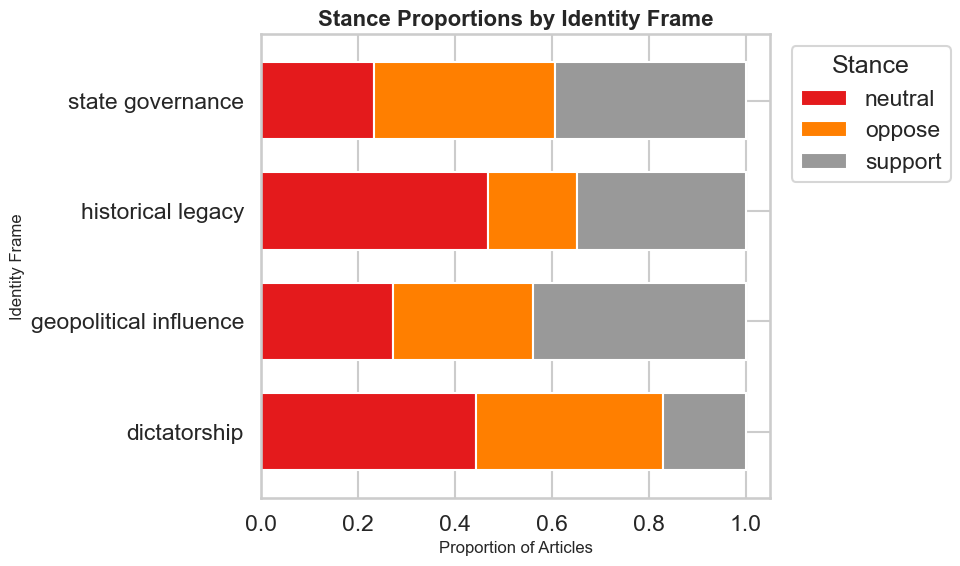

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Build a crosstab of counts
stance_counts = pd.crosstab(nyt_df['merged_label'], nyt_df['stance'])

# 2) Convert to proportions
stance_prop = stance_counts.div(stance_counts.sum(axis=1), axis=0)

# 3) Create a bigger figure & axes
fig, ax = plt.subplots(figsize=(10, 6))

# 4) Plot onto that axes
stance_prop.plot(
    kind='barh',
    stacked=True,
    colormap='Set1',
    width=0.7,
    ax=ax
)

# 5) Tidy up labels, title, legend
ax.set_title("Stance Proportions by Identity Frame", fontsize=16, weight='bold')
ax.set_xlabel("Proportion of Articles", fontsize=12)
ax.set_ylabel("Identity Frame", fontsize=12)
ax.legend(title="Stance", bbox_to_anchor=(1.02, 1), loc='upper left')

# 6) Layout
plt.tight_layout()
plt.show()

/var/folders/0k/7z1g8vr51n7_n_22vk6x3zrw0000gn/T/ipykernel_80011/2776285894.py:76: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  bottom_ax.set_xticklabels(labels)


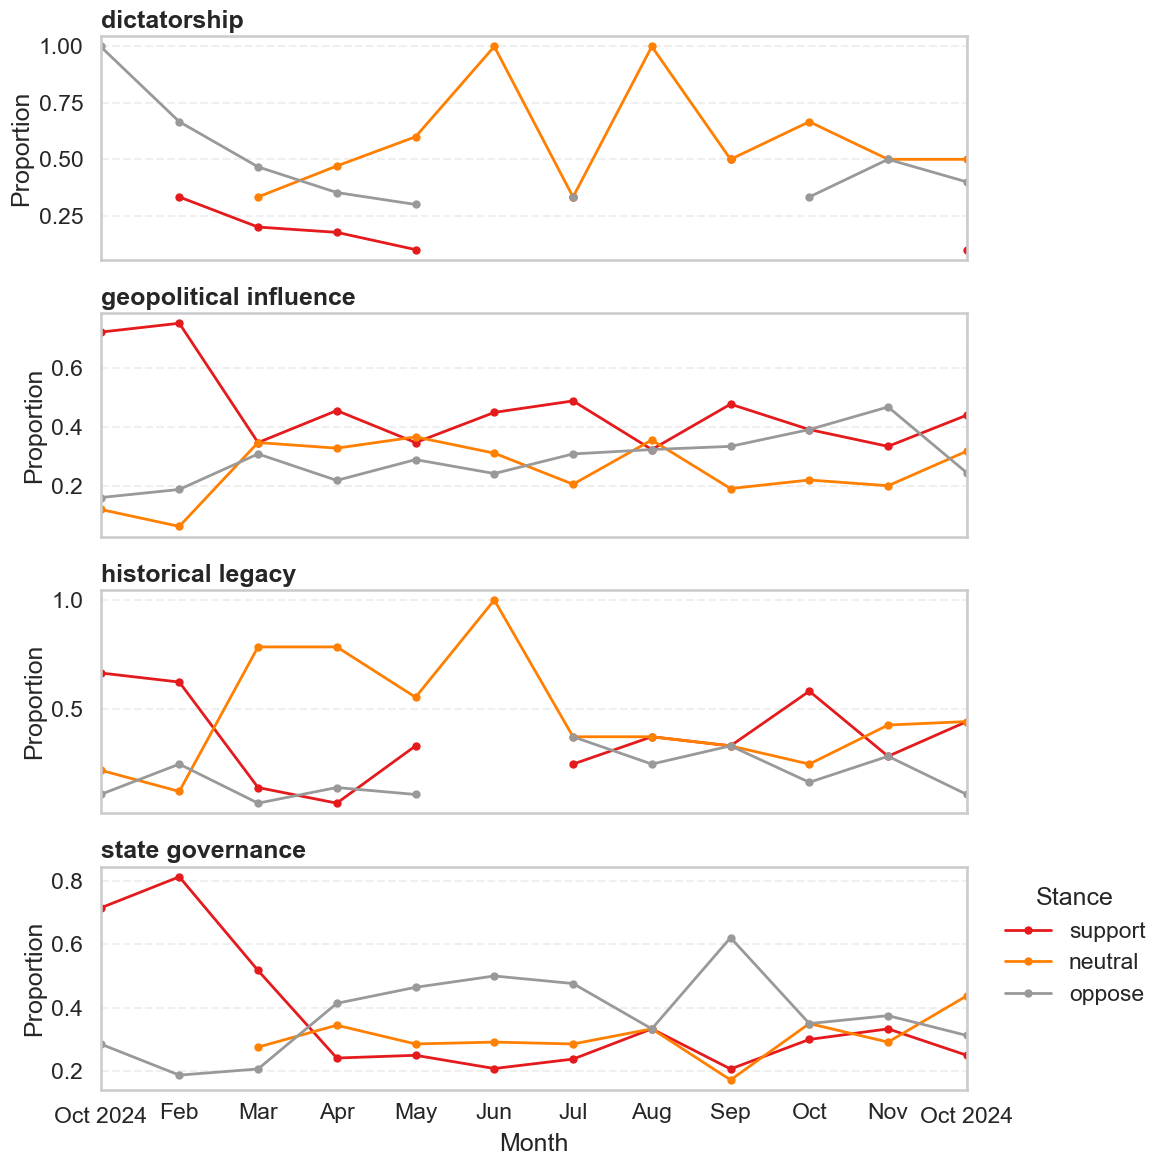

<Figure size 640x480 with 0 Axes>

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# 0) Prepare your month column once
nyt_df['pub_date'] = pd.to_datetime(nyt_df['pub_date'])
nyt_df['month']    = nyt_df['pub_date'].dt.to_period('M').dt.to_timestamp()

# 1) Build long‐form counts + proportions
df_ts = (
    nyt_df
    .groupby(['month','merged_label','stance'])
    .size()
    .rename('count')
    .reset_index()
)
df_ts['total'] = df_ts.groupby(['month','merged_label'])['count'].transform('sum')
df_ts['prop']  = df_ts['count'] / df_ts['total']

# 2) Figure setup
frames = sorted(df_ts['merged_label'].unique())
n = len(frames)
fig, axes = plt.subplots(n, 1, figsize=(12, 3*n), sharex=True)

# global min/max for clamping
min_month = df_ts['month'].min()
max_month = df_ts['month'].max()

# 3) Plot each frame
for ax, frame in zip(axes, frames):
    df_frame = (
        df_ts[df_ts['merged_label'] == frame]
        .pivot(index='month', columns='stance', values='prop')
        .reindex(columns=['support','neutral','oppose'], fill_value=0)
    )
    df_frame.plot(
        ax=ax,
        marker='o',
        linewidth=2,
        markersize=5,
        colormap='Set1',
        legend=False
    )
    ax.set_title(frame, loc='left', weight='bold')
    ax.set_ylabel("Proportion")
    ax.grid(alpha=0.3, linestyle='--')
    # clamp x‐axis here for every panel
    ax.set_xlim(min_month, max_month)
    # hide x‐labels except on bottom
    ax.tick_params(labelbottom=False)

# 4) Format bottom axis
bottom_ax = axes[-1]
bottom_ax.tick_params(labelbottom=True)
bottom_ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
bottom_ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
bottom_ax.set_xlabel("Month")

# 5) Shared legend
bottom_ax.legend(
    title='Stance',
    bbox_to_anchor=(1.02,1),
    loc='upper left',
    frameon=False
)
# … your plotting code up to setting the bottom axis formatter …

# >>> RIGHT AFTER:
# bottom_ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
# bottom_ax.set_xlabel("Month")

# FIX any “1971” → “2024” in the labels:
labels = [lbl.get_text().replace('1971','2024') 
          for lbl in bottom_ax.get_xticklabels()]
bottom_ax.set_xticklabels(labels)

plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()

# suprevised model


In [ ]:
# import pandas as pd

# # 1) How many per frame?
# counts = nyt_df['merged_label'].value_counts()
# print("Articles per frame before sampling:\n", counts)

# # 2) Stratified sample: up to 50 articles per frame
# sampled = (
#     nyt_df
#     .groupby('merged_label', group_keys=False)
#     .apply(lambda grp: grp.sample(n=min(len(grp), 50), random_state=42))
#     .reset_index(drop=True)
# )

# # 3) Inspect breakdown
# print("\nSampled articles per frame:\n", sampled['merged_label'].value_counts())

# # 4) Export for annotation (clean_text + current merged_label as context)
# sampled[['clean_text','merged_label']] \
#     .to_csv('frame_annotation_sample.csv', index=False)

# print("\nExported", len(sampled), "rows to frame_annotation_sample.csv")
